In [1]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

In [13]:
!pip install scikit-neuralnetwork

     |████████████████████████████████| 2.8 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 15.3 MB/s eta 0:00:01
  Created wheel for scikit-neuralnetwork: filename=scikit_neuralnetwork-0.7-py3-none-any.whl size=41698 sha256=5fdab674fc12e85b4416716f10bc99ec8f8771f210af5ae3815b0acfd5158d01
  Stored in directory: /home/misbah/.cache/pip/wheels/32/68/e9/8d101abd9783af57c4fc7d0f757551f1e8c78ee1d522417cfd
  Created wheel for Lasagne: filename=Lasagne-0.1-py3-none-any.whl size=79283 sha256=4e4c2e994233cb6358170d565c159e8eb75fbe8b5b422a84f44e289db1cf9b63
  Stored in directory: /home/misbah/.cache/pip/wheels/b9/77/1a/ea5fb64846a17e27d33c290668ea73be7038d7ce643d3882c0
  Created wheel for Theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=d2adb9136fffb60790902983f3abc4cac0b40bee4b1cd0c5f67bc5acc77debda
  Stored in directory: /home/misbah/.cache/pip/wheels/7f/80/57/2970ddd2e4961d84fb0d58196f4965deead046d29e08693e73
Successfully built scikit-neuralnetwork Las

In [2]:
cd ../../../src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [3]:
rm -rf trials

In [4]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

In [5]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y.values-Y_obs.values)/np.sqrt(Y_scalar)
#Y_np = np.array([Yi.flatten() for Yi in Y_np])

In [6]:
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [7]:
index=np.random.choice(250,50)
X_test=X_s[index]
Y_test=Y_np[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X_s[Index_x_bool]
Y_train=Y_np[Index_x_bool]

In [8]:
Y_train.shape

(205, 24, 48)

In [30]:
# Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

latent_dim = 32


class Autoencoder(Model):
    def __init__(self, latent_dim, data_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim  
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim*2, activation='relu'),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(latent_dim*2, activation='relu'),
          layers.Dense(data_dim[0]*data_dim[1], activation='sigmoid'),
          layers.Reshape(data_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim, Y_train.shape[1:]) 
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(Y_train, Y_train,
                epochs=200,
                shuffle=True,
                validation_data=(Y_test, Y_test))

Epoch 1/200
7/7 [==============================] - 0s 12ms/step - loss: 0.2255 - val_loss: 0.1998
Epoch 2/200
7/7 [==============================] - 0s 4ms/step - loss: 0.1657 - val_loss: 0.1085
Epoch 3/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0820 - val_loss: 0.0525
Epoch 4/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0490 - val_loss: 0.0417
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0389
Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0399 - val_loss: 0.0368
Epoch 7/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0377 - val_loss: 0.0347
Epoch 8/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0353 - val_loss: 0.0324
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0328 - val_loss: 0.0301
Epoch 10/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0281
Epoch 11/200
7/7 [==========

7/7 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 86/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 87/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0186
Epoch 88/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0186
Epoch 89/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 90/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 91/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 92/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0185
Epoch 93/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0185
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 168/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 169/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 170/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 171/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 172/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 173/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 174/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 176/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 177/200
7/7 [=====

In [31]:
encoded_Y_train = autoencoder.encoder(Y_train).numpy()
encoded_Y_test = autoencoder.encoder(Y_test).numpy()

In [37]:
encoded_Y_train.shape

(205, 32)

In [38]:
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [49]:
def build_model_PCA(hp):
    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(5,)))
    model.add(tf.keras.layers.Flatten())
    model.add(keras.layers.Dense(
    units=hp.Int("units", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", ["relu", "tanh","leaky_relu"]))
    )
#     if hp.Boolean("dropout"):
#         model.add(keras.layers.Dropout(rate=0.25))
        
    model.add(keras.layers.Dense(
    units=hp.Int("units2", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", ["relu", "tanh","leaky_relu"]))
    )
    model.add(keras.layers.Dense(
    units=hp.Int("units3", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", "leaky_relu"))
    )
    model.add(keras.layers.Dense(latent_dim, activation='leaky_relu'))
    hp_learning_rate=hp.Choice("learning_rate",values=[1e-2,1e-3,1e-4])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
    return model

In [40]:
tuner = kt.Hyperband(
    build_model_PCA,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    overwrite=True,
    directory='trials',)

In [41]:
tuner.search(X_train, encoded_Y_train, epochs=50, validation_data=(X_test, encoded_Y_test))

Trial 30 Complete [00h 00m 00s]
val_loss: 1.3461440801620483

Best val_loss So Far: 0.8109667897224426
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 5)                 20        
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 20)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2592      
Total params: 6,852
Trainable params: 6,842
Non-trainable params: 10
_____________________________________________________

In [43]:
Y_Pred=best_model.predict(X_test)

In [44]:
Y_orig_test=autoencoder.decoder(Y_Pred)



In [45]:
mse=np.mean(np.square(Y_orig_test-Y_test))

In [46]:
rmse=np.sqrt(mse)

In [47]:
print("mse is:",mse,"rmse:",rmse)

mse is: 0.020267146 rmse: 0.14236273


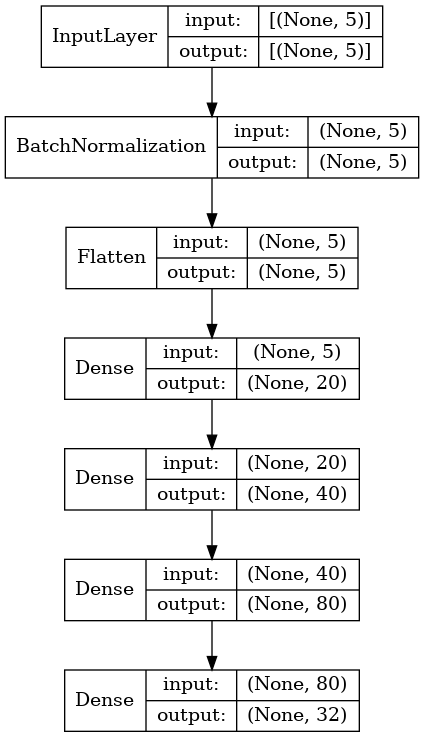

In [48]:
plot_model(best_model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)